# Learn CNN


CNN_model7 uses 2 convolutional layers .
Dataset can be downloaded in http://www.montefiore.ulg.ac.be/services/acous/STSI/downloads.php

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
from saveTransformedGraph import optimizeGraph
import scipy.io.wavfile
import time
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import *


modelName = "CNN1"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("Experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("Experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)

# directory that will contain tensorboard information
pathLog = 'Tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.8
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = 0
num_step = 150                                       # time step before reduction
conv_chan = [35 , 70]                                # number of kernels for convolution
conv_strides = 3                                     # delay between two convolution
conv_size = 12                                       # filter size for the convolution
size_poll = 4
reg_scale = 0
l1l2Prop = 0.4  
reg_scale_l1 = l1l2Prop*reg_scale
reg_scale_l2 = ((1-l1l2Prop)/2)*reg_scale
num_hidden = 1000                                    # num of hidden units
num_class = 1                                        # size of the output
num_feature = 1                                      # size of the input
batch_size = 1000                                    # number of sequence taken before to compute the gradient
n_layer = 2                                          

#num_hidden = num_hidden/keep_prob
num_epoch = 10000                                    # process all the datas num_epoch times
trainDuration = 60*60*15                              # or during a determined duration(second)
amplifierName = 'EnglDisto'
fileNameTrain = 'Datasets/training'+amplifierName+'.mat'             #dataset train/test path
fileNameTest = 'Datasets/test'+amplifierName+'.mat' # dataset validation path
fileNameValidation = 'Datasets/val'+amplifierName+'.mat'

#############################
# Loading data
#############################
matrix = sio.loadmat(fileNameTrain)
matrixTrain = matrix['train']
matrix = sio.loadmat(fileNameTest)
matrixTest = matrix['test']
if maxSize ==0:
    maxSize = len(matrixTrain)
    print("maxSize = {}".format(maxSize))

train_input,train_output,test_input,test_output = loadInputOutputSeq(matrixTrain,matrixTest,num_step,maxSize)

print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")

#######################
# Graph Construction
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data")
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") 
     
    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,1,1])
    dataShaped = tf.transpose(dataShaped,[0,3,1,2]) 
    
    with tf.variable_scope("ConvLayers"):
        regularizerC1 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC1")
        conv1 = tf.layers.conv2d(inputs = dataShaped,filters = conv_chan[0],
                                       kernel_size = (conv_size,1),strides=(3,1),
                                       padding = "same",activation=tf.nn.relu,kernel_regularizer=regularizerC1,
                                       data_format='channels_first',name="conv1")
        
        # pool1
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 1, 3, 1], strides=[1, 1, 2, 1],data_format='NCHW',padding='SAME', name='pool1')  
        regularizerC2 = tf.contrib.layers.l1_l2_regularizer(scale_l1=reg_scale_l1,scale_l2=reg_scale_l2,scope="regC2")
        conv2 = tf.layers.conv2d(inputs = pool1,filters = conv_chan[1],
                                       kernel_size = (conv_size/2,1),strides=(1,1),
                                       padding = "same",activation=tf.nn.relu,kernel_regularizer=regularizerC1,
                                       data_format='channels_first',name="conv2")
        

        # pool2
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 1, 3, 1], strides=[1, 1, 2, 1],data_format='NCHW',padding='SAME', name='pool2')
        
    # reshape pool 2 cnn to make a fully connected layer entry
    dataShape = int(np.prod(pool2.get_shape()[1:]))
    dataReshaped = tf.reshape(pool2, [-1, dataShape])
    FC1 = fully_connected(dataReshaped,1000,activation_fn=tf.nn.relu,weights_regularizer=None,scope="FC1")

    intermediate = FC1
    prediction = fully_connected(FC1,int(target.get_shape()[1]),activation_fn=tf.nn.tanh,weights_regularizer=None,scope="FCPred")

    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    EnergyTarget = tf.reduce_mean(tf.square(target)) 
    
    #get regularizer
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    MSEReg = tf.add_n([MSE]+reg_losses,name="MSEReg")
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSEReg)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
##############################
# Graph execution
##############################
    
with tf.Session(graph=G) as sess:

    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')
    
    no_of_batches = int(np.floor((numTrain)/batch_size)) 
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    NRMSETest = 10
    bestNRMSETest = 1    
    # train until the number of epochs or the training time is reached
    for epoch in range(num_epoch):
        tEpoch = time.clock()
        if (time.clock()-tStart < trainDuration) :
            ptr = 0
            if epoch % 20==0 : # each twenty epochs save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'myModel.ckpt'))
            
            pMSETrain=0
            pEnergyTarget=0
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                ptr+=batch_size
                
                if j % np.floor(numTrain/len(test_input)) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,summary_op,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
                    step = epoch*no_of_batches+j
                    # save the training RMSE for tensorboard
                    train_writer.add_summary(summary_str,step)                   

                else :
                    _,pMSETrainTemp,pEnergyTargetTemp = sess.run([minimize,MSE,EnergyTarget],{data: inp, target: out})
                    pMSETrain += pMSETrainTemp
                    pEnergyTarget += pEnergyTargetTemp
            # compute an estimation of the RMSE for this epoch       
            MSETrain = pMSETrain/no_of_batches
            EnergyTargetTrain = pEnergyTarget/no_of_batches
            NRMSETrain = np.sqrt(MSETrain/EnergyTargetTrain)
            print ("Epoch -{} calculated in {:5.2f} s ".format(epoch,time.clock()-tEpoch))
            
            # evaluate the model on the test set 
            pMSE = 0
            ptr2 = 0
            pEnergyTarget = 0
            for k in range(no_of_batchesTest):
                pMSETemp,pEnergyTargetTemp,summary_str = sess.run([MSE,EnergyTarget,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2 += batch_size
                pEnergyTarget+=pEnergyTargetTemp
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*np.floor(numTrain/len(test_input)))
            MSETest = pMSE/no_of_batchesTest
            EnergyTargetTest = pEnergyTarget/no_of_batchesTest
            NRMSETest = np.sqrt(MSETest/EnergyTargetTest)
            if NRMSETest<bestNRMSETest:
                bestNRMSETest=NRMSETest
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myBestGraph.pbtxt',as_text=True)
                save_path = saver.save(sess,os.path.join(pathTemp,'myBestModel.ckpt'))
            print("Epoch {}, NRMSE Test/best: {:.5f}/{:.5f}, Training NRMSE: {:.5f}, deviation of {:.2f}%".format(epoch,NRMSETest,bestNRMSETest,NRMSETrain,100*np.sqrt((NRMSETrain-NRMSETest)**2)/NRMSETrain))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
   
    ################################################################
    # Save Graph variable and information about the running session
    ################################################################
    # save graph
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pbtxt',as_text=True)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = bestNRMSETest
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    infoLog["conv_chan"] = conv_chan
    infoLog["strides"] = conv_strides
    infoLog["conv_size"] = conv_size
    infoLog["amplifierName"]=amplifierName
    logPerf(infoLog)
    input_nodes=["placeHolder/data"]
    output_nodes=["FCPred/Tanh"]
    optimizeGraph(pathTemp,input_nodes,output_nodes)
    
    
                                                 
    
    ###############################
    #  Validation
    ###############################
    restorePath = os.path.join(pathTemp,'myBestModel.ckpt') # restore the best model
    saver.restore(sess,restorePath)
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['val']  
    valSize = 0
    if valSize == 0 :
        valSize = len(matrixVal)

    val_input,val_output = loadValidationSeq(matrixVal,num_step,valSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size

    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[6000+num_step:6700+num_step],label='prediction')
    ax.plot(targetArray[6000+num_step:6700+num_step],label='target')
    ax.legend()
    plt.xlabel('sample n')
    plt.ylabel('Amplitude y[n]')
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")



version 1.13.1 of tensorflow
maxSize = 6726407
shape input train (6726258, 150)
Data loaded
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Scale of 0 disables regularizer.
Epoch -0 calculated in 23.54 s 
Epoch 0, NRMSE Test/best: 0.68159/0.68159, Training NRMSE: 0.52527, deviation of 29.76%
Epoch -1 calculated in 22.58 s 
Epoch 1, NRMSE Test/best: 0.60938/0.60938, Training NRMSE: 0.45394, deviation of 34.24%
Epoch -2 calculated in 22.93 s 
Epoch 2, NRMSE Test/best: 0.56893/0.56893, Training NRMSE: 0.42776, deviation of 33.00%
Epoch -3 calculated in 22.96 s 
Epoch 3, NRMSE Test/best: 0.53572/0.53572, Training NRMSE: 0.42012, deviation of 27.52%
Epoch -4 calculated in 22.79 s 
Epoch 4, NRMSE Test/best: 0.53741/0.53572, Training NRMSE: 0.40865, deviation of 31.51%
Epoch -5 calculated in 22.80 s 
Epoch 5, NRMSE Test/best: 0.54954/0.53572, Tra

Epoch -62 calculated in 22.38 s 
Epoch 62, NRMSE Test/best: 0.48116/0.46346, Training NRMSE: 0.32175, deviation of 49.55%
Epoch -63 calculated in 22.25 s 
Epoch 63, NRMSE Test/best: 0.48453/0.46346, Training NRMSE: 0.32258, deviation of 50.21%
Epoch -64 calculated in 22.13 s 
Epoch 64, NRMSE Test/best: 0.48725/0.46346, Training NRMSE: 0.32903, deviation of 48.09%
Epoch -65 calculated in 22.27 s 
Epoch 65, NRMSE Test/best: 0.48807/0.46346, Training NRMSE: 0.32382, deviation of 50.72%
Epoch -66 calculated in 22.26 s 
Epoch 66, NRMSE Test/best: 0.50012/0.46346, Training NRMSE: 0.32004, deviation of 56.27%
Epoch -67 calculated in 22.38 s 
Epoch 67, NRMSE Test/best: 0.50339/0.46346, Training NRMSE: 0.32011, deviation of 57.25%
Epoch -68 calculated in 22.26 s 
Epoch 68, NRMSE Test/best: 0.49026/0.46346, Training NRMSE: 0.32154, deviation of 52.47%
Epoch -69 calculated in 22.39 s 
Epoch 69, NRMSE Test/best: 0.51063/0.46346, Training NRMSE: 0.32002, deviation of 59.56%
Epoch -70 calculated in 

Epoch -129 calculated in 22.46 s 
Epoch 129, NRMSE Test/best: 0.43991/0.43203, Training NRMSE: 0.30417, deviation of 44.63%
Epoch -130 calculated in 22.18 s 
Epoch 130, NRMSE Test/best: 0.43363/0.43203, Training NRMSE: 0.30562, deviation of 41.89%
Epoch -131 calculated in 22.47 s 
Epoch 131, NRMSE Test/best: 0.44036/0.43203, Training NRMSE: 0.30458, deviation of 44.58%
Epoch -132 calculated in 22.26 s 
Epoch 132, NRMSE Test/best: 0.43410/0.43203, Training NRMSE: 0.30391, deviation of 42.84%
Epoch -133 calculated in 22.26 s 
Epoch 133, NRMSE Test/best: 0.44388/0.43203, Training NRMSE: 0.30489, deviation of 45.58%
Epoch -134 calculated in 22.36 s 
Epoch 134, NRMSE Test/best: 0.43660/0.43203, Training NRMSE: 0.30503, deviation of 43.13%
Epoch -135 calculated in 22.42 s 
Epoch 135, NRMSE Test/best: 0.44171/0.43203, Training NRMSE: 0.30259, deviation of 45.98%
Epoch -136 calculated in 22.31 s 
Epoch 136, NRMSE Test/best: 0.44360/0.43203, Training NRMSE: 0.30290, deviation of 46.45%
Epoch -1

Epoch 195, NRMSE Test/best: 0.46020/0.43203, Training NRMSE: 0.29627, deviation of 55.33%
Epoch -196 calculated in 22.17 s 
Epoch 196, NRMSE Test/best: 0.46452/0.43203, Training NRMSE: 0.29895, deviation of 55.39%
Epoch -197 calculated in 22.32 s 
Epoch 197, NRMSE Test/best: 0.46611/0.43203, Training NRMSE: 0.29541, deviation of 57.78%
Epoch -198 calculated in 22.40 s 
Epoch 198, NRMSE Test/best: 0.46901/0.43203, Training NRMSE: 0.29618, deviation of 58.35%
Epoch -199 calculated in 22.48 s 
Epoch 199, NRMSE Test/best: 0.47861/0.43203, Training NRMSE: 0.29579, deviation of 61.81%
Epoch -200 calculated in 22.51 s 
Epoch 200, NRMSE Test/best: 0.47618/0.43203, Training NRMSE: 0.29561, deviation of 61.09%
Epoch -201 calculated in 22.37 s 
Epoch 201, NRMSE Test/best: 0.46894/0.43203, Training NRMSE: 0.29634, deviation of 58.24%
Epoch -202 calculated in 22.32 s 
Epoch 202, NRMSE Test/best: 0.46514/0.43203, Training NRMSE: 0.29660, deviation of 56.83%
Epoch -203 calculated in 22.32 s 
Epoch 20

Epoch -262 calculated in 22.39 s 
Epoch 262, NRMSE Test/best: 0.44625/0.43203, Training NRMSE: 0.29128, deviation of 53.20%
Epoch -263 calculated in 22.54 s 
Epoch 263, NRMSE Test/best: 0.44297/0.43203, Training NRMSE: 0.29406, deviation of 50.64%
Epoch -264 calculated in 22.40 s 
Epoch 264, NRMSE Test/best: 0.45093/0.43203, Training NRMSE: 0.29098, deviation of 54.97%
Epoch -265 calculated in 22.24 s 
Epoch 265, NRMSE Test/best: 0.44361/0.43203, Training NRMSE: 0.29382, deviation of 50.98%
Epoch -266 calculated in 22.39 s 
Epoch 266, NRMSE Test/best: 0.44503/0.43203, Training NRMSE: 0.29131, deviation of 52.77%
Epoch -267 calculated in 22.24 s 
Epoch 267, NRMSE Test/best: 0.45429/0.43203, Training NRMSE: 0.29074, deviation of 56.25%
Epoch -268 calculated in 22.49 s 
Epoch 268, NRMSE Test/best: 0.45942/0.43203, Training NRMSE: 0.29128, deviation of 57.73%
Epoch -269 calculated in 22.30 s 
Epoch 269, NRMSE Test/best: 0.45184/0.43203, Training NRMSE: 0.29109, deviation of 55.22%
Epoch -2

Epoch 328, NRMSE Test/best: 0.45727/0.43203, Training NRMSE: 0.28830, deviation of 58.61%
Epoch -329 calculated in 22.24 s 
Epoch 329, NRMSE Test/best: 0.45037/0.43203, Training NRMSE: 0.28957, deviation of 55.53%
Epoch -330 calculated in 22.45 s 
Epoch 330, NRMSE Test/best: 0.44971/0.43203, Training NRMSE: 0.28885, deviation of 55.69%
Epoch -331 calculated in 22.34 s 
Epoch 331, NRMSE Test/best: 0.45378/0.43203, Training NRMSE: 0.28823, deviation of 57.44%
Epoch -332 calculated in 21.99 s 
Epoch 332, NRMSE Test/best: 0.45593/0.43203, Training NRMSE: 0.28849, deviation of 58.04%
Epoch -333 calculated in 22.14 s 
Epoch 333, NRMSE Test/best: 0.44715/0.43203, Training NRMSE: 0.28869, deviation of 54.89%
Epoch -334 calculated in 22.22 s 
Epoch 334, NRMSE Test/best: 0.45514/0.43203, Training NRMSE: 0.28958, deviation of 57.17%
Epoch -335 calculated in 22.41 s 
Epoch 335, NRMSE Test/best: 0.45095/0.43203, Training NRMSE: 0.29068, deviation of 55.13%
Epoch -336 calculated in 22.11 s 
Epoch 33

Epoch -395 calculated in 22.49 s 
Epoch 395, NRMSE Test/best: 0.46008/0.43203, Training NRMSE: 0.28830, deviation of 59.59%
Epoch -396 calculated in 22.49 s 
Epoch 396, NRMSE Test/best: 0.46346/0.43203, Training NRMSE: 0.28859, deviation of 60.59%
Epoch -397 calculated in 22.65 s 
Epoch 397, NRMSE Test/best: 0.46370/0.43203, Training NRMSE: 0.28739, deviation of 61.35%
Epoch -398 calculated in 22.45 s 
Epoch 398, NRMSE Test/best: 0.45974/0.43203, Training NRMSE: 0.28773, deviation of 59.78%
Epoch -399 calculated in 22.35 s 
Epoch 399, NRMSE Test/best: 0.46936/0.43203, Training NRMSE: 0.28805, deviation of 62.94%
Epoch -400 calculated in 22.49 s 
Epoch 400, NRMSE Test/best: 0.46550/0.43203, Training NRMSE: 0.28857, deviation of 61.31%
Epoch -401 calculated in 22.38 s 
Epoch 401, NRMSE Test/best: 0.47401/0.43203, Training NRMSE: 0.28952, deviation of 63.72%
Epoch -402 calculated in 22.21 s 
Epoch 402, NRMSE Test/best: 0.46746/0.43203, Training NRMSE: 0.28807, deviation of 62.27%
Epoch -4

Epoch 461, NRMSE Test/best: 0.46242/0.43203, Training NRMSE: 0.28632, deviation of 61.51%
Epoch -462 calculated in 22.52 s 
Epoch 462, NRMSE Test/best: 0.46086/0.43203, Training NRMSE: 0.28568, deviation of 61.32%
Epoch -463 calculated in 22.40 s 
Epoch 463, NRMSE Test/best: 0.46094/0.43203, Training NRMSE: 0.28557, deviation of 61.41%
Epoch -464 calculated in 22.43 s 
Epoch 464, NRMSE Test/best: 0.46265/0.43203, Training NRMSE: 0.28692, deviation of 61.25%
Epoch -465 calculated in 22.29 s 
Epoch 465, NRMSE Test/best: 0.46602/0.43203, Training NRMSE: 0.28761, deviation of 62.03%
Epoch -466 calculated in 22.39 s 
Epoch 466, NRMSE Test/best: 0.45900/0.43203, Training NRMSE: 0.28466, deviation of 61.24%
Epoch -467 calculated in 22.41 s 
Epoch 467, NRMSE Test/best: 0.46105/0.43203, Training NRMSE: 0.28892, deviation of 59.58%
Epoch -468 calculated in 22.33 s 
Epoch 468, NRMSE Test/best: 0.46166/0.43203, Training NRMSE: 0.28614, deviation of 61.34%
Epoch -469 calculated in 22.60 s 
Epoch 46

Epoch -528 calculated in 22.30 s 
Epoch 528, NRMSE Test/best: 0.44741/0.43203, Training NRMSE: 0.28633, deviation of 56.26%
Epoch -529 calculated in 22.44 s 
Epoch 529, NRMSE Test/best: 0.45473/0.43203, Training NRMSE: 0.28400, deviation of 60.11%
Epoch -530 calculated in 22.43 s 
Epoch 530, NRMSE Test/best: 0.45296/0.43203, Training NRMSE: 0.28361, deviation of 59.71%
Epoch -531 calculated in 22.36 s 
Epoch 531, NRMSE Test/best: 0.45259/0.43203, Training NRMSE: 0.28321, deviation of 59.81%
Epoch -532 calculated in 22.46 s 
Epoch 532, NRMSE Test/best: 0.45414/0.43203, Training NRMSE: 0.28451, deviation of 59.62%
Epoch -533 calculated in 22.34 s 
Epoch 533, NRMSE Test/best: 0.44572/0.43203, Training NRMSE: 0.28388, deviation of 57.01%
Epoch -534 calculated in 22.39 s 
Epoch 534, NRMSE Test/best: 0.44868/0.43203, Training NRMSE: 0.28297, deviation of 58.56%
Epoch -535 calculated in 22.26 s 
Epoch 535, NRMSE Test/best: 0.44793/0.43203, Training NRMSE: 0.28187, deviation of 58.92%
Epoch -5

Epoch 594, NRMSE Test/best: 0.43671/0.43203, Training NRMSE: 0.28102, deviation of 55.40%
Epoch -595 calculated in 22.52 s 
Epoch 595, NRMSE Test/best: 0.44497/0.43203, Training NRMSE: 0.28095, deviation of 58.38%
Epoch -596 calculated in 22.46 s 
Epoch 596, NRMSE Test/best: 0.43820/0.43203, Training NRMSE: 0.28179, deviation of 55.51%
Epoch -597 calculated in 22.29 s 
Epoch 597, NRMSE Test/best: 0.44192/0.43203, Training NRMSE: 0.28096, deviation of 57.29%
Epoch -598 calculated in 22.29 s 
Epoch 598, NRMSE Test/best: 0.43680/0.43203, Training NRMSE: 0.28041, deviation of 55.77%
Epoch -599 calculated in 22.22 s 
Epoch 599, NRMSE Test/best: 0.43998/0.43203, Training NRMSE: 0.28589, deviation of 53.90%
Epoch -600 calculated in 22.26 s 
Epoch 600, NRMSE Test/best: 0.44290/0.43203, Training NRMSE: 0.28158, deviation of 57.29%
Epoch -601 calculated in 22.36 s 
Epoch 601, NRMSE Test/best: 0.44226/0.43203, Training NRMSE: 0.28073, deviation of 57.54%
Epoch -602 calculated in 22.35 s 
Epoch 60

Epoch -661 calculated in 22.24 s 
Epoch 661, NRMSE Test/best: 0.43948/0.42978, Training NRMSE: 0.27992, deviation of 57.00%
Epoch -662 calculated in 22.33 s 
Epoch 662, NRMSE Test/best: 0.44391/0.42978, Training NRMSE: 0.28054, deviation of 58.24%
Epoch -663 calculated in 22.54 s 
Epoch 663, NRMSE Test/best: 0.43136/0.42978, Training NRMSE: 0.28048, deviation of 53.80%
Epoch -664 calculated in 22.54 s 
Epoch 664, NRMSE Test/best: 0.43285/0.42978, Training NRMSE: 0.27833, deviation of 55.52%
Epoch -665 calculated in 22.54 s 
Epoch 665, NRMSE Test/best: 0.43533/0.42978, Training NRMSE: 0.27923, deviation of 55.90%
Epoch -666 calculated in 22.46 s 
Epoch 666, NRMSE Test/best: 0.43281/0.42978, Training NRMSE: 0.28026, deviation of 54.43%
Epoch -667 calculated in 22.35 s 
Epoch 667, NRMSE Test/best: 0.43775/0.42978, Training NRMSE: 0.28041, deviation of 56.11%
Epoch -668 calculated in 22.43 s 
Epoch 668, NRMSE Test/best: 0.43659/0.42978, Training NRMSE: 0.28002, deviation of 55.91%
Epoch -6

Epoch 727, NRMSE Test/best: 0.44659/0.42978, Training NRMSE: 0.28059, deviation of 59.16%
Epoch -728 calculated in 22.44 s 
Epoch 728, NRMSE Test/best: 0.44784/0.42978, Training NRMSE: 0.27803, deviation of 61.08%
Epoch -729 calculated in 22.43 s 
Epoch 729, NRMSE Test/best: 0.44506/0.42978, Training NRMSE: 0.27805, deviation of 60.06%
Epoch -730 calculated in 22.60 s 
Epoch 730, NRMSE Test/best: 0.45123/0.42978, Training NRMSE: 0.27979, deviation of 61.28%
Epoch -731 calculated in 22.21 s 
Epoch 731, NRMSE Test/best: 0.45113/0.42978, Training NRMSE: 0.28217, deviation of 59.88%
Epoch -732 calculated in 22.29 s 
Epoch 732, NRMSE Test/best: 0.45019/0.42978, Training NRMSE: 0.27901, deviation of 61.35%
Epoch -733 calculated in 22.59 s 
Epoch 733, NRMSE Test/best: 0.44696/0.42978, Training NRMSE: 0.27877, deviation of 60.33%
Epoch -734 calculated in 22.51 s 
Epoch 734, NRMSE Test/best: 0.45432/0.42978, Training NRMSE: 0.27820, deviation of 63.31%
Epoch -735 calculated in 22.51 s 
Epoch 73

Epoch -794 calculated in 22.41 s 
Epoch 794, NRMSE Test/best: 0.46194/0.42978, Training NRMSE: 0.27836, deviation of 65.95%
Epoch -795 calculated in 22.35 s 
Epoch 795, NRMSE Test/best: 0.45470/0.42978, Training NRMSE: 0.28013, deviation of 62.32%
Epoch -796 calculated in 22.41 s 
Epoch 796, NRMSE Test/best: 0.46292/0.42978, Training NRMSE: 0.27971, deviation of 65.50%
Epoch -797 calculated in 22.41 s 
Epoch 797, NRMSE Test/best: 0.45285/0.42978, Training NRMSE: 0.28003, deviation of 61.72%
Epoch -798 calculated in 22.44 s 
Epoch 798, NRMSE Test/best: 0.45576/0.42978, Training NRMSE: 0.27961, deviation of 63.00%
Epoch -799 calculated in 22.53 s 
Epoch 799, NRMSE Test/best: 0.45969/0.42978, Training NRMSE: 0.27778, deviation of 65.49%
Epoch -800 calculated in 22.65 s 
Epoch 800, NRMSE Test/best: 0.45596/0.42978, Training NRMSE: 0.28023, deviation of 62.71%
Epoch -801 calculated in 22.32 s 
Epoch 801, NRMSE Test/best: 0.45612/0.42978, Training NRMSE: 0.27855, deviation of 63.75%
Epoch -8

Epoch 860, NRMSE Test/best: 0.44743/0.42978, Training NRMSE: 0.27896, deviation of 60.39%
Epoch -861 calculated in 22.47 s 
Epoch 861, NRMSE Test/best: 0.45031/0.42978, Training NRMSE: 0.27689, deviation of 62.63%
Epoch -862 calculated in 22.44 s 
Epoch 862, NRMSE Test/best: 0.44805/0.42978, Training NRMSE: 0.27728, deviation of 61.58%
Epoch -863 calculated in 22.60 s 
Epoch 863, NRMSE Test/best: 0.44869/0.42978, Training NRMSE: 0.27569, deviation of 62.75%
Epoch -864 calculated in 22.55 s 
Epoch 864, NRMSE Test/best: 0.45009/0.42978, Training NRMSE: 0.27714, deviation of 62.41%
Epoch -865 calculated in 22.59 s 
Epoch 865, NRMSE Test/best: 0.45564/0.42978, Training NRMSE: 0.27755, deviation of 64.17%
Epoch -866 calculated in 22.50 s 
Epoch 866, NRMSE Test/best: 0.45118/0.42978, Training NRMSE: 0.27749, deviation of 62.59%
Epoch -867 calculated in 22.59 s 
Epoch 867, NRMSE Test/best: 0.45119/0.42978, Training NRMSE: 0.27681, deviation of 62.99%
Epoch -868 calculated in 22.67 s 
Epoch 86

Epoch -927 calculated in 22.45 s 
Epoch 927, NRMSE Test/best: 0.44781/0.42978, Training NRMSE: 0.28441, deviation of 57.45%
Epoch -928 calculated in 22.26 s 
Epoch 928, NRMSE Test/best: 0.43669/0.42978, Training NRMSE: 0.27718, deviation of 57.55%
Epoch -929 calculated in 22.35 s 
Epoch 929, NRMSE Test/best: 0.45259/0.42978, Training NRMSE: 0.27783, deviation of 62.90%
Epoch -930 calculated in 22.58 s 
Epoch 930, NRMSE Test/best: 0.44045/0.42978, Training NRMSE: 0.27889, deviation of 57.93%
Epoch -931 calculated in 22.21 s 
Epoch 931, NRMSE Test/best: 0.44734/0.42978, Training NRMSE: 0.27751, deviation of 61.20%
Epoch -932 calculated in 22.40 s 
Epoch 932, NRMSE Test/best: 0.44314/0.42978, Training NRMSE: 0.27860, deviation of 59.06%
Epoch -933 calculated in 22.51 s 
Epoch 933, NRMSE Test/best: 0.44721/0.42978, Training NRMSE: 0.27783, deviation of 60.96%
Epoch -934 calculated in 22.42 s 
Epoch 934, NRMSE Test/best: 0.44534/0.42978, Training NRMSE: 0.28026, deviation of 58.90%
Epoch -9

Epoch 993, NRMSE Test/best: 0.44621/0.42978, Training NRMSE: 0.27727, deviation of 60.93%
Epoch -994 calculated in 22.47 s 
Epoch 994, NRMSE Test/best: 0.44552/0.42978, Training NRMSE: 0.27919, deviation of 59.57%
Epoch -995 calculated in 22.61 s 
Epoch 995, NRMSE Test/best: 0.43897/0.42978, Training NRMSE: 0.28251, deviation of 55.38%
Epoch -996 calculated in 22.38 s 
Epoch 996, NRMSE Test/best: 0.45017/0.42978, Training NRMSE: 0.27750, deviation of 62.22%
Epoch -997 calculated in 22.55 s 
Epoch 997, NRMSE Test/best: 0.45593/0.42978, Training NRMSE: 0.27647, deviation of 64.91%
Epoch -998 calculated in 22.40 s 
Epoch 998, NRMSE Test/best: 0.44313/0.42978, Training NRMSE: 0.27746, deviation of 59.71%
Epoch -999 calculated in 22.44 s 
Epoch 999, NRMSE Test/best: 0.44811/0.42978, Training NRMSE: 0.27713, deviation of 61.70%
Epoch -1000 calculated in 22.54 s 
Epoch 1000, NRMSE Test/best: 0.45478/0.42978, Training NRMSE: 0.27745, deviation of 63.91%
Epoch -1001 calculated in 22.37 s 
Epoch

Epoch -1059 calculated in 22.53 s 
Epoch 1059, NRMSE Test/best: 0.44143/0.42978, Training NRMSE: 0.27621, deviation of 59.82%
Epoch -1060 calculated in 22.44 s 
Epoch 1060, NRMSE Test/best: 0.44388/0.42978, Training NRMSE: 0.27751, deviation of 59.95%
Epoch -1061 calculated in 22.27 s 
Epoch 1061, NRMSE Test/best: 0.44465/0.42978, Training NRMSE: 0.27765, deviation of 60.15%
Epoch -1062 calculated in 22.46 s 
Epoch 1062, NRMSE Test/best: 0.44100/0.42978, Training NRMSE: 0.27807, deviation of 58.60%
Epoch -1063 calculated in 22.04 s 
Epoch 1063, NRMSE Test/best: 0.43841/0.42978, Training NRMSE: 0.27815, deviation of 57.62%
Epoch -1064 calculated in 22.41 s 
Epoch 1064, NRMSE Test/best: 0.44448/0.42978, Training NRMSE: 0.27551, deviation of 61.33%
Epoch -1065 calculated in 22.57 s 
Epoch 1065, NRMSE Test/best: 0.45113/0.42978, Training NRMSE: 0.27717, deviation of 62.76%
Epoch -1066 calculated in 22.35 s 
Epoch 1066, NRMSE Test/best: 0.44582/0.42978, Training NRMSE: 0.27579, deviation of

Epoch 1124, NRMSE Test/best: 0.45994/0.42978, Training NRMSE: 0.27769, deviation of 65.63%
Epoch -1125 calculated in 22.38 s 
Epoch 1125, NRMSE Test/best: 0.46326/0.42978, Training NRMSE: 0.27781, deviation of 66.76%
Epoch -1126 calculated in 22.37 s 
Epoch 1126, NRMSE Test/best: 0.46977/0.42978, Training NRMSE: 0.27707, deviation of 69.55%
Epoch -1127 calculated in 22.53 s 
Epoch 1127, NRMSE Test/best: 0.46636/0.42978, Training NRMSE: 0.27603, deviation of 68.95%
Epoch -1128 calculated in 22.59 s 
Epoch 1128, NRMSE Test/best: 0.45342/0.42978, Training NRMSE: 0.27830, deviation of 62.93%
Epoch -1129 calculated in 22.61 s 
Epoch 1129, NRMSE Test/best: 0.45602/0.42978, Training NRMSE: 0.27719, deviation of 64.52%
Epoch -1130 calculated in 22.41 s 
Epoch 1130, NRMSE Test/best: 0.45805/0.42978, Training NRMSE: 0.27839, deviation of 64.54%
Epoch -1131 calculated in 22.38 s 
Epoch 1131, NRMSE Test/best: 0.45220/0.42978, Training NRMSE: 0.27583, deviation of 63.94%
Epoch -1132 calculated in 2

Epoch -1190 calculated in 22.36 s 
Epoch 1190, NRMSE Test/best: 0.45103/0.42978, Training NRMSE: 0.28018, deviation of 60.98%
Epoch -1191 calculated in 22.57 s 
Epoch 1191, NRMSE Test/best: 0.46312/0.42978, Training NRMSE: 0.27619, deviation of 67.68%
Epoch -1192 calculated in 22.65 s 
Epoch 1192, NRMSE Test/best: 0.45268/0.42978, Training NRMSE: 0.27597, deviation of 64.03%
Epoch -1193 calculated in 22.17 s 
Epoch 1193, NRMSE Test/best: 0.45653/0.42978, Training NRMSE: 0.27461, deviation of 66.25%
Epoch -1194 calculated in 22.41 s 
Epoch 1194, NRMSE Test/best: 0.46291/0.42978, Training NRMSE: 0.27514, deviation of 68.24%
Epoch -1195 calculated in 22.52 s 
Epoch 1195, NRMSE Test/best: 0.46103/0.42978, Training NRMSE: 0.27763, deviation of 66.06%
Epoch -1196 calculated in 22.53 s 
Epoch 1196, NRMSE Test/best: 0.47312/0.42978, Training NRMSE: 0.27741, deviation of 70.55%
Epoch -1197 calculated in 22.42 s 
Epoch 1197, NRMSE Test/best: 0.46477/0.42978, Training NRMSE: 0.27539, deviation of

Epoch 1255, NRMSE Test/best: 0.44768/0.42978, Training NRMSE: 0.27700, deviation of 61.62%
Epoch -1256 calculated in 22.53 s 
Epoch 1256, NRMSE Test/best: 0.44461/0.42978, Training NRMSE: 0.27975, deviation of 58.93%
Epoch -1257 calculated in 22.27 s 
Epoch 1257, NRMSE Test/best: 0.45384/0.42978, Training NRMSE: 0.27651, deviation of 64.13%
Epoch -1258 calculated in 22.36 s 
Epoch 1258, NRMSE Test/best: 0.44607/0.42978, Training NRMSE: 0.27440, deviation of 62.56%
Epoch -1259 calculated in 22.63 s 
Epoch 1259, NRMSE Test/best: 0.45576/0.42978, Training NRMSE: 0.27607, deviation of 65.09%
Epoch -1260 calculated in 22.48 s 
Epoch 1260, NRMSE Test/best: 0.45166/0.42978, Training NRMSE: 0.27602, deviation of 63.63%
Epoch -1261 calculated in 22.64 s 
Epoch 1261, NRMSE Test/best: 0.45111/0.42978, Training NRMSE: 0.27501, deviation of 64.03%
Epoch -1262 calculated in 22.41 s 
Epoch 1262, NRMSE Test/best: 0.45582/0.42978, Training NRMSE: 0.27636, deviation of 64.93%
Epoch -1263 calculated in 2

Epoch -1321 calculated in 22.32 s 
Epoch 1321, NRMSE Test/best: 0.45444/0.42978, Training NRMSE: 0.27836, deviation of 63.25%
Epoch -1322 calculated in 22.39 s 
Epoch 1322, NRMSE Test/best: 0.44886/0.42978, Training NRMSE: 0.27676, deviation of 62.18%
Epoch -1323 calculated in 22.44 s 
Epoch 1323, NRMSE Test/best: 0.45456/0.42978, Training NRMSE: 0.27778, deviation of 63.64%
Epoch -1324 calculated in 22.35 s 
Epoch 1324, NRMSE Test/best: 0.45380/0.42978, Training NRMSE: 0.27818, deviation of 63.13%
Epoch -1325 calculated in 22.36 s 
Epoch 1325, NRMSE Test/best: 0.45381/0.42978, Training NRMSE: 0.27689, deviation of 63.89%
Epoch -1326 calculated in 22.36 s 
Epoch 1326, NRMSE Test/best: 0.45140/0.42978, Training NRMSE: 0.27762, deviation of 62.60%
Epoch -1327 calculated in 22.39 s 
Epoch 1327, NRMSE Test/best: 0.45039/0.42978, Training NRMSE: 0.27803, deviation of 61.99%
Epoch -1328 calculated in 22.51 s 
Epoch 1328, NRMSE Test/best: 0.45556/0.42978, Training NRMSE: 0.27708, deviation of

Epoch 1386, NRMSE Test/best: 0.44664/0.42978, Training NRMSE: 0.27846, deviation of 60.39%
Epoch -1387 calculated in 22.46 s 
Epoch 1387, NRMSE Test/best: 0.44361/0.42978, Training NRMSE: 0.27758, deviation of 59.81%
Epoch -1388 calculated in 22.57 s 
Epoch 1388, NRMSE Test/best: 0.44457/0.42978, Training NRMSE: 0.27494, deviation of 61.70%
Epoch -1389 calculated in 22.28 s 
Epoch 1389, NRMSE Test/best: 0.44084/0.42978, Training NRMSE: 0.27506, deviation of 60.27%
Epoch -1390 calculated in 22.44 s 
Epoch 1390, NRMSE Test/best: 0.44838/0.42978, Training NRMSE: 0.27667, deviation of 62.06%
Epoch -1391 calculated in 22.65 s 
Epoch 1391, NRMSE Test/best: 0.44193/0.42978, Training NRMSE: 0.27609, deviation of 60.07%
Epoch -1392 calculated in 22.12 s 
Epoch 1392, NRMSE Test/best: 0.44649/0.42978, Training NRMSE: 0.27566, deviation of 61.97%
Epoch -1393 calculated in 22.44 s 
Epoch 1393, NRMSE Test/best: 0.44598/0.42978, Training NRMSE: 0.27914, deviation of 59.77%
Epoch -1394 calculated in 2

Epoch -1452 calculated in 22.60 s 
Epoch 1452, NRMSE Test/best: 0.45446/0.42978, Training NRMSE: 0.27444, deviation of 65.60%
Epoch -1453 calculated in 22.45 s 
Epoch 1453, NRMSE Test/best: 0.45942/0.42978, Training NRMSE: 0.27673, deviation of 66.02%
Epoch -1454 calculated in 22.58 s 
Epoch 1454, NRMSE Test/best: 0.46493/0.42978, Training NRMSE: 0.27562, deviation of 68.68%
Epoch -1455 calculated in 22.43 s 
Epoch 1455, NRMSE Test/best: 0.45854/0.42978, Training NRMSE: 0.27488, deviation of 66.81%
Epoch -1456 calculated in 22.41 s 
Epoch 1456, NRMSE Test/best: 0.46227/0.42978, Training NRMSE: 0.27750, deviation of 66.59%
Epoch -1457 calculated in 22.57 s 
Epoch 1457, NRMSE Test/best: 0.45516/0.42978, Training NRMSE: 0.27535, deviation of 65.30%
Epoch -1458 calculated in 22.59 s 
Epoch 1458, NRMSE Test/best: 0.45818/0.42978, Training NRMSE: 0.27397, deviation of 67.24%
Epoch -1459 calculated in 22.61 s 
Epoch 1459, NRMSE Test/best: 0.45775/0.42978, Training NRMSE: 0.27507, deviation of

Epoch 1517, NRMSE Test/best: 0.45845/0.42978, Training NRMSE: 0.27780, deviation of 65.03%
Epoch -1518 calculated in 22.29 s 
Epoch 1518, NRMSE Test/best: 0.45277/0.42978, Training NRMSE: 0.27650, deviation of 63.75%
Epoch -1519 calculated in 22.35 s 
Epoch 1519, NRMSE Test/best: 0.45820/0.42978, Training NRMSE: 0.27486, deviation of 66.71%
Epoch -1520 calculated in 22.59 s 
Epoch 1520, NRMSE Test/best: 0.45110/0.42978, Training NRMSE: 0.27674, deviation of 63.00%
Epoch -1521 calculated in 22.36 s 
Epoch 1521, NRMSE Test/best: 0.45386/0.42978, Training NRMSE: 0.27587, deviation of 64.52%
Epoch -1522 calculated in 22.31 s 
Epoch 1522, NRMSE Test/best: 0.45737/0.42978, Training NRMSE: 0.27712, deviation of 65.04%
Epoch -1523 calculated in 22.42 s 
Epoch 1523, NRMSE Test/best: 0.45522/0.42978, Training NRMSE: 0.27666, deviation of 64.54%
Epoch -1524 calculated in 22.56 s 
Epoch 1524, NRMSE Test/best: 0.44282/0.42978, Training NRMSE: 0.27486, deviation of 61.11%
Epoch -1525 calculated in 2

Epoch -1583 calculated in 22.39 s 
Epoch 1583, NRMSE Test/best: 0.44533/0.42978, Training NRMSE: 0.27427, deviation of 62.37%
Epoch -1584 calculated in 22.26 s 
Epoch 1584, NRMSE Test/best: 0.44858/0.42978, Training NRMSE: 0.27392, deviation of 63.76%
Epoch -1585 calculated in 22.26 s 
Epoch 1585, NRMSE Test/best: 0.44760/0.42978, Training NRMSE: 0.27701, deviation of 61.58%
Epoch -1586 calculated in 22.49 s 
Epoch 1586, NRMSE Test/best: 0.44544/0.42978, Training NRMSE: 0.27538, deviation of 61.76%
Epoch -1587 calculated in 22.46 s 
Epoch 1587, NRMSE Test/best: 0.44998/0.42978, Training NRMSE: 0.27724, deviation of 62.30%
Epoch -1588 calculated in 22.51 s 
Epoch 1588, NRMSE Test/best: 0.44451/0.42978, Training NRMSE: 0.27433, deviation of 62.04%
Epoch -1589 calculated in 22.33 s 
Epoch 1589, NRMSE Test/best: 0.44665/0.42978, Training NRMSE: 0.27469, deviation of 62.60%
Epoch -1590 calculated in 22.43 s 
Epoch 1590, NRMSE Test/best: 0.44722/0.42978, Training NRMSE: 0.27553, deviation of

Epoch 1648, NRMSE Test/best: 0.45330/0.42978, Training NRMSE: 0.27431, deviation of 65.25%
Epoch -1649 calculated in 22.36 s 
Epoch 1649, NRMSE Test/best: 0.44829/0.42978, Training NRMSE: 0.27359, deviation of 63.86%
Epoch -1650 calculated in 22.26 s 
Epoch 1650, NRMSE Test/best: 0.45296/0.42978, Training NRMSE: 0.27673, deviation of 63.68%
Epoch -1651 calculated in 22.57 s 
Epoch 1651, NRMSE Test/best: 0.45808/0.42978, Training NRMSE: 0.27460, deviation of 66.81%
Epoch -1652 calculated in 22.60 s 
Epoch 1652, NRMSE Test/best: 0.44484/0.42978, Training NRMSE: 0.27548, deviation of 61.48%
Epoch -1653 calculated in 22.48 s 
Epoch 1653, NRMSE Test/best: 0.45383/0.42978, Training NRMSE: 0.27636, deviation of 64.21%
Epoch -1654 calculated in 22.38 s 
Epoch 1654, NRMSE Test/best: 0.45425/0.42978, Training NRMSE: 0.28158, deviation of 61.32%
Epoch -1655 calculated in 22.44 s 
Epoch 1655, NRMSE Test/best: 0.45493/0.42978, Training NRMSE: 0.27514, deviation of 65.35%
Epoch -1656 calculated in 2

Epoch -1714 calculated in 22.62 s 
Epoch 1714, NRMSE Test/best: 0.44038/0.42978, Training NRMSE: 0.27483, deviation of 60.23%
Epoch -1715 calculated in 22.32 s 
Epoch 1715, NRMSE Test/best: 0.43993/0.42978, Training NRMSE: 0.27548, deviation of 59.70%
Epoch -1716 calculated in 22.69 s 
Epoch 1716, NRMSE Test/best: 0.44870/0.42978, Training NRMSE: 0.27715, deviation of 61.90%
Epoch -1717 calculated in 22.62 s 
Epoch 1717, NRMSE Test/best: 0.43956/0.42978, Training NRMSE: 0.27626, deviation of 59.11%
Epoch -1718 calculated in 22.43 s 
Epoch 1718, NRMSE Test/best: 0.44257/0.42978, Training NRMSE: 0.27592, deviation of 60.40%
Epoch -1719 calculated in 22.33 s 
Epoch 1719, NRMSE Test/best: 0.44049/0.42978, Training NRMSE: 0.28093, deviation of 56.80%
Epoch -1720 calculated in 22.55 s 
Epoch 1720, NRMSE Test/best: 0.43497/0.42978, Training NRMSE: 0.27499, deviation of 58.18%
Epoch -1721 calculated in 22.54 s 
Epoch 1721, NRMSE Test/best: 0.43838/0.42978, Training NRMSE: 0.27801, deviation of

Epoch 1779, NRMSE Test/best: 0.44438/0.42769, Training NRMSE: 0.27336, deviation of 62.56%
Epoch -1780 calculated in 22.50 s 
Epoch 1780, NRMSE Test/best: 0.44864/0.42769, Training NRMSE: 0.27516, deviation of 63.04%
Epoch -1781 calculated in 22.24 s 
Epoch 1781, NRMSE Test/best: 0.44740/0.42769, Training NRMSE: 0.27245, deviation of 64.21%
Epoch -1782 calculated in 22.34 s 
Epoch 1782, NRMSE Test/best: 0.45036/0.42769, Training NRMSE: 0.27293, deviation of 65.01%
Epoch -1783 calculated in 22.54 s 
Epoch 1783, NRMSE Test/best: 0.44217/0.42769, Training NRMSE: 0.27525, deviation of 60.64%
Epoch -1784 calculated in 22.54 s 
Epoch 1784, NRMSE Test/best: 0.45500/0.42769, Training NRMSE: 0.27492, deviation of 65.50%
Epoch -1785 calculated in 22.35 s 
Epoch 1785, NRMSE Test/best: 0.44171/0.42769, Training NRMSE: 0.27545, deviation of 60.36%
Epoch -1786 calculated in 22.52 s 
Epoch 1786, NRMSE Test/best: 0.45936/0.42769, Training NRMSE: 0.27474, deviation of 67.20%
Epoch -1787 calculated in 2

Epoch -1845 calculated in 22.58 s 
Epoch 1845, NRMSE Test/best: 0.45050/0.42769, Training NRMSE: 0.27377, deviation of 64.55%
Epoch -1846 calculated in 22.34 s 
Epoch 1846, NRMSE Test/best: 0.45550/0.42769, Training NRMSE: 0.27495, deviation of 65.67%
Epoch -1847 calculated in 22.46 s 
Epoch 1847, NRMSE Test/best: 0.45537/0.42769, Training NRMSE: 0.27502, deviation of 65.58%
Epoch -1848 calculated in 22.28 s 
Epoch 1848, NRMSE Test/best: 0.45836/0.42769, Training NRMSE: 0.27606, deviation of 66.04%
Epoch -1849 calculated in 22.35 s 
Epoch 1849, NRMSE Test/best: 0.45390/0.42769, Training NRMSE: 0.27451, deviation of 65.35%
Epoch -1850 calculated in 22.36 s 
Epoch 1850, NRMSE Test/best: 0.45252/0.42769, Training NRMSE: 0.27526, deviation of 64.40%
Epoch -1851 calculated in 22.30 s 
Epoch 1851, NRMSE Test/best: 0.45874/0.42769, Training NRMSE: 0.27822, deviation of 64.88%
Epoch -1852 calculated in 22.36 s 
Epoch 1852, NRMSE Test/best: 0.45844/0.42769, Training NRMSE: 0.27407, deviation of

Epoch 1910, NRMSE Test/best: 0.44652/0.42769, Training NRMSE: 0.27470, deviation of 62.55%
Epoch -1911 calculated in 22.31 s 
Epoch 1911, NRMSE Test/best: 0.44471/0.42769, Training NRMSE: 0.27616, deviation of 61.03%
Epoch -1912 calculated in 22.37 s 
Epoch 1912, NRMSE Test/best: 0.44568/0.42769, Training NRMSE: 0.27441, deviation of 62.42%
Epoch -1913 calculated in 22.46 s 
Epoch 1913, NRMSE Test/best: 0.44144/0.42769, Training NRMSE: 0.27551, deviation of 60.23%
Epoch -1914 calculated in 22.37 s 
Epoch 1914, NRMSE Test/best: 0.43987/0.42769, Training NRMSE: 0.27571, deviation of 59.54%
Epoch -1915 calculated in 22.29 s 
Epoch 1915, NRMSE Test/best: 0.44129/0.42769, Training NRMSE: 0.27409, deviation of 61.00%
Epoch -1916 calculated in 22.37 s 
Epoch 1916, NRMSE Test/best: 0.44669/0.42769, Training NRMSE: 0.27857, deviation of 60.35%
Epoch -1917 calculated in 22.40 s 
Epoch 1917, NRMSE Test/best: 0.44359/0.42769, Training NRMSE: 0.27549, deviation of 61.02%
Epoch -1918 calculated in 2

Epoch -1976 calculated in 22.38 s 
Epoch 1976, NRMSE Test/best: 0.45818/0.42769, Training NRMSE: 0.27341, deviation of 67.58%
Epoch -1977 calculated in 22.35 s 
Epoch 1977, NRMSE Test/best: 0.44598/0.42769, Training NRMSE: 0.27750, deviation of 60.71%
Epoch -1978 calculated in 22.34 s 
Epoch 1978, NRMSE Test/best: 0.45379/0.42769, Training NRMSE: 0.27649, deviation of 64.12%
Epoch -1979 calculated in 22.65 s 
Epoch 1979, NRMSE Test/best: 0.45563/0.42769, Training NRMSE: 0.27487, deviation of 65.76%
Epoch -1980 calculated in 22.32 s 
Epoch 1980, NRMSE Test/best: 0.45398/0.42769, Training NRMSE: 0.27448, deviation of 65.40%
Epoch -1981 calculated in 22.52 s 
Epoch 1981, NRMSE Test/best: 0.45723/0.42769, Training NRMSE: 0.27750, deviation of 64.77%
Epoch -1982 calculated in 22.66 s 
Epoch 1982, NRMSE Test/best: 0.45671/0.42769, Training NRMSE: 0.27481, deviation of 66.20%
Epoch -1983 calculated in 22.35 s 
Epoch 1983, NRMSE Test/best: 0.45603/0.42769, Training NRMSE: 0.27738, deviation of

Epoch 2041, NRMSE Test/best: 0.44448/0.42769, Training NRMSE: 0.27498, deviation of 61.64%
Epoch -2042 calculated in 22.40 s 
Epoch 2042, NRMSE Test/best: 0.45160/0.42769, Training NRMSE: 0.27245, deviation of 65.76%
Epoch -2043 calculated in 22.36 s 
Epoch 2043, NRMSE Test/best: 0.44280/0.42769, Training NRMSE: 0.27519, deviation of 60.91%
Epoch -2044 calculated in 22.10 s 
Epoch 2044, NRMSE Test/best: 0.44762/0.42769, Training NRMSE: 0.27340, deviation of 63.73%
Epoch -2045 calculated in 22.55 s 
Epoch 2045, NRMSE Test/best: 0.44966/0.42769, Training NRMSE: 0.27789, deviation of 61.82%
Epoch -2046 calculated in 22.64 s 
Epoch 2046, NRMSE Test/best: 0.45193/0.42769, Training NRMSE: 0.27300, deviation of 65.54%
Epoch -2047 calculated in 22.41 s 
Epoch 2047, NRMSE Test/best: 0.45164/0.42769, Training NRMSE: 0.27313, deviation of 65.35%
Epoch -2048 calculated in 22.61 s 
Epoch 2048, NRMSE Test/best: 0.45041/0.42769, Training NRMSE: 0.27435, deviation of 64.18%
Epoch -2049 calculated in 2

<IPython.core.display.Javascript object>


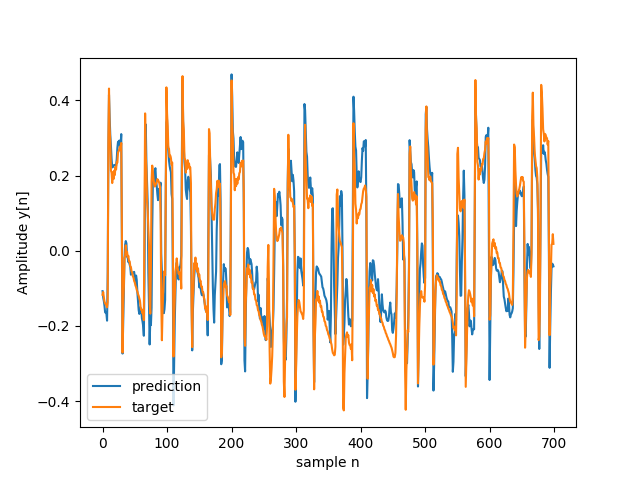

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)